In [5]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import equinox as eqx
from jax import random, jit, lax
from functools import partial

from pathlib import Path
from tqdm import tqdm
from typing import Any, Optional
from dataclasses import dataclass

# Load dataset

In [2]:
def load_idx_images(path):
    with open(path, "rb") as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype=">i4")
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data.reshape(num, rows * cols)  # flatten


def load_idx_labels(path):
    with open(path, "rb") as f:
        magic, num = np.frombuffer(f.read(8), dtype=">i4")
        return np.frombuffer(f.read(), dtype=np.uint8)


def load_mnist_from_archive(archive_path='archive'):
    '''
    load the data and normalize it to the [-1,1] range

    '''
    archive_path = Path(archive_path)

    train_images = load_idx_images(archive_path / "train-images.idx3-ubyte")
    train_labels = load_idx_labels(archive_path / "train-labels.idx1-ubyte")

    test_images  = load_idx_images(archive_path / "t10k-images.idx3-ubyte")
    test_labels  = load_idx_labels(archive_path / "t10k-labels.idx1-ubyte")

    N  = 784
    Nc = 10
    Ns  = train_images.shape[0]
    NsT = test_images.shape[0]

    M  = 2 * (train_images / 255.0) - 1
    MT = 2 * (test_images  / 255.0) - 1

    M  = M.T
    MT = MT.T

    Lab  = -np.ones((Nc, Ns))
    LabT = -np.ones((Nc, NsT))

    Lab[train_labels, np.arange(Ns)] = 1.0
    LabT[test_labels, np.arange(NsT)] = 1.0
    
    M = jnp.array(M)
    Lab = jnp.array(Lab)
    MT = jnp.array(MT)
    LabT = jnp.array(LabT)

    return M, Lab, MT, LabT

In [10]:
N=784 
Nc=10 
Ns=60000 
NsT=10000

M, Lab, MT, LabT = load_mnist_from_archive('archive')

# Visualization

In [14]:
def draw_heatmap(synapses, Kx, Ky, fig=None, title=None):

    if fig is None:
        fig = plt.figure(figsize=(6, 6))
    fig.clf()
    ax = fig.add_subplot(111)

    syn_np = np.array(synapses)
    syn_np = np.nan_to_num(syn_np, nan=0.0, posinf=0.0, neginf=0.0)

    K = syn_np.shape[0]
    expected_K = Kx * Ky
    if K != expected_K:
         raise ValueError(f"draw_heatmap: expected K={expected_K} (=Kx*Ky) but got K={K}")

    HM = np.zeros((28 * Ky, 28 * Kx))
    yy = 0
    for y in range(Ky):
        for x in range(Kx):
            patch = syn_np[yy, :].reshape(28, 28)
            patch = np.nan_to_num(patch, nan=0.0, posinf=0.0, neginf=0.0)
            HM[y * 28:(y + 1) * 28, x * 28:(x + 1) * 28] = patch
            yy += 1

    if np.all(HM == 0):
        vmin, vmax = -1.0, 1.0
    else:
        nm = np.nanmax(np.abs(HM))
        vmin, vmax = (-nm, nm) if nm != 0 else (-1.0, 1.0)

    im = ax.imshow(HM, cmap='bwr', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax, ticks=[np.nanmin(HM), 0, np.nanmax(HM)])
    ax.axis('off')
    if title is not None:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()
    return fig

In [24]:
def plot_errors(err_tr, err_test, fig=None, save_path=None):
    if fig is None:
        fig = plt.figure(figsize=(8, 5))
    fig.clf()
    ax = fig.add_subplot(111)

    err_tr_np = np.array(err_tr)
    err_test_np = np.array(err_test)

    epochs_tr = np.arange(1, len(err_tr_np) + 1)
    epochs_test = np.arange(1, len(err_test_np) + 1)

    ax.plot(epochs_tr, err_tr_np, label='train', linewidth=2)
    ax.plot(epochs_test, err_test_np, label='test', linewidth=2)

    ax.set_xlabel('number of epochs')
    ax.set_ylabel('error (%)')
    ax.set_ylim(0, 100)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.4)
    # plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=200)

    plt.show()
    return fig

# Model

This cell defines parameters of the algorithm: 

`n` - power of the rectified polynomial in Eq 3:
$$
F(x) =  \begin{cases} 
      x^n, & x \geq 0 \\
      0,   & x < 0 
   \end{cases}  \tag{3}
$$

`m` - power of the loss function in Eq 14; 
$$
C = \sum_{\text{training examples}} \sum_{\alpha=1}^{N_c} (c_\alpha - t_\alpha)^{2m} \tag{14}
$$

`K` - number of memories that are displayed as an `Ky` by `Kx` array by the visualization function defined above (used for visualization only); 

`eps0` - initial learning rate that is exponentially annealed during training with the damping parameter `f`, as explained in Eq 12; 
$$
\varepsilon (t) = \varepsilon_0 f^t, f = 0.998 \tag{12}
$$

`p` - momentum as defined in Eq 13; 
$$
V_I^\mu(t) = p V_I^\mu(t-1) - \partial_{\xi_I^\mu} C \\

\xi_I^\mu(t) = \xi_I^\mu(t-1) + \varepsilon \frac{V_I^\mu(t)}{\max\limits_{J}|V_J^\mu(t)|} \tag{13}
$$
`mu` - the mean of the gaussian distribution that initializes the weights;  

`sigma` - the standard deviation of that gaussian;  

`Nep` - number of epochs; 

`Num` - size of the training minibatch; `NumT` - size of the test minibatch; 

`prec` - parameter that controls numerical precision of the weight updates. 

Parameter `beta` that is used in Eq 9 is defined as `beta=1/Temp**n`. 
$$
c_{\alpha} = g \left[
    \beta \sum_{\mu = 1}^K \left(F(-\xi_{\alpha}^{\mu} x_{\alpha} + \sum_{\gamma \neq \alpha}\xi_{\gamma}^{\mu} x_{\gamma} + \sum_{i=1}^N \xi_{i}^{\mu} v_i)   -
    F(\xi_{\alpha}^{\mu} x_{\alpha} + \sum_{\gamma \neq \alpha}\xi_{\gamma}^{\mu} x_{\gamma} + \sum_{i=1}^N \xi_{i}^{\mu} v_i) \right)
\right] \tag{9}
$$

The choice of temperatures `Temp` as well as the duration of the annealing `thresh_pret` is discussed in Appendix A.


In [16]:
Kx = 10              # Number of memories per row on the weights plot
Ky = 10              # Number of memories per column on the weigths plot
K = Kx*Ky            # Number of memories
n = 20               # Power of the interaction vertex in the DAM energy function
m = 30               # Power of the loss function
eps0 = 4.0e-2        # Initial learning rate  
f = 0.998            # Damping parameter for the learning rate
p = 0.6              # Momentum
Nep = 300            # Number of epochs
Temp_in = 540.       # Initial temperature
Temp_f = 540.        # Final temperature
thresh_pret = 200    # Length of the temperature ramp
Num = 1000           # Size of training minibatch     
NumT = 5000          # Size of test minibatch 
mu = -0.3            # Weights initialization mean
sigma = 0.3          # Weights initialization std
prec = 1.0e-30       # Precision of weight update

In [17]:
@partial(jit, static_argnums=(7, 8, 9, 10, 11, 12))
def training_step(KS, VKS, v, t_R, aux, beta, eps, p, prec, n, m, Nc, Num):
    t = jnp.reshape(t_R, (1, Nc * Num))
    
    u = jnp.concatenate((v, -jnp.ones((Nc, Num))), axis=0)
    uu = jnp.tile(u, (1, Nc))
    vv = jnp.concatenate((uu[:N, :], aux), axis=0)
    
    KSvv = jnp.maximum(jnp.dot(KS, vv), 0)
    KSuu = jnp.maximum(jnp.dot(KS, uu), 0)
    
    Y = jnp.tanh(beta * jnp.sum(KSvv**n - KSuu**n, axis=0))
    Y_R = jnp.reshape(Y, (Nc, Num))
    
    # gradients of the loss function
    factor = (t - Y)**(2*m - 1) * (1 - Y) * (1 + Y)
    d_KS = (jnp.dot(jnp.tile(factor, (K, 1)) * KSvv**(n-1), vv.T) - 
            jnp.dot(jnp.tile(factor, (K, 1)) * KSuu**(n-1), uu.T))
    
    VKS_new = p * VKS + d_KS
    nc = jnp.max(jnp.abs(VKS_new), axis=1, keepdims=True)
    nc = jnp.where(nc < prec, prec, nc)
    ncc = jnp.tile(nc, (1, N + Nc))
    KS_new = KS + eps * VKS_new / ncc
    KS_new = jnp.clip(KS_new, -1., 1.)
    
    correct = jnp.argmax(Y_R, axis=0) == jnp.argmax(t_R, axis=0)
    num_correct = jnp.sum(correct)
    
    return KS_new, VKS_new, num_correct

# test step
@partial(jit, static_argnums=(4, 5, 6, 7))
def test_step(KS, v, t_R, auxT, beta, n, Nc, NumT):
    u = jnp.concatenate((v, -jnp.ones((Nc, NumT))), axis=0)
    uu = jnp.tile(u, (1, Nc))
    vv = jnp.concatenate((uu[:N, :], auxT), axis=0)
    
    KSvv = jnp.maximum(jnp.dot(KS, vv), 0)
    KSuu = jnp.maximum(jnp.dot(KS, uu), 0)
    
    Y = jnp.tanh(beta * jnp.sum(KSvv**n - KSuu**n, axis=0))
    Y_R = jnp.reshape(Y, (Nc, NumT))
    
    correct = jnp.argmax(Y_R, axis=0) == jnp.argmax(t_R, axis=0)
    return jnp.sum(correct)

This cell defines the main code. The external loop runs over epochs nep, the internal loop runs over minibatches. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate eps at that epoch, see Eq 13. The weights are displayed by the helper function after each epoch.

In [8]:
key = random.PRNGKey(19)
KS = random.normal(key, (K, N + Nc)) * sigma + mu
VKS = jnp.zeros((K, N + Nc))

aux = -jnp.ones((Nc, Num * Nc))
for d in range(Nc):
    aux = aux.at[d, d*Num:(d+1)*Num].set(1.)

auxT = -jnp.ones((Nc, NumT * Nc))
for d in range(Nc):
    auxT = auxT.at[d, d*NumT:(d+1)*NumT].set(1.)

err_tr = []
err_test = []

for nep in tqdm(range(Nep)):
    eps = eps0 * f**nep
    
    if nep <= thresh_pret:
        Temp = Temp_in + (Temp_f - Temp_in) * nep / thresh_pret
    else:
        Temp = Temp_f
    beta = 1.0 / Temp**n

    key, subkey = random.split(key)
    perm = random.permutation(subkey, Ns)
    M_shuffled = M[:, perm]
    Lab_shuffled = Lab[:, perm]
    
    total_correct = 0
    for k in range(Ns // Num):
        v = M_shuffled[:, k*Num:(k+1)*Num]
        t_R = Lab_shuffled[:, k*Num:(k+1)*Num]
        
        KS, VKS, num_correct = training_step(KS, VKS, v, t_R, aux, beta, eps, p, prec, n, m, Nc, Num)
        total_correct += num_correct
    
    err_tr.append(100.0 * (1.0 - total_correct / Ns))
    
    total_correct_test = 0
    for k in range(NsT // NumT):
        v = MT[:, k*NumT:(k+1)*NumT]
        t_R = LabT[:, k*NumT:(k+1)*NumT]
        
        num_correct = test_step(KS, v, t_R, auxT, beta, n, Nc, NumT)
        total_correct_test += num_correct
    
    err_test.append(100.0 * (1.0 - total_correct_test / NsT))

    KS_np = np.array(KS[:, :N])

100%|██████████| 300/300 [00:45<00:00,  6.58it/s]


<Figure size 640x480 with 0 Axes>

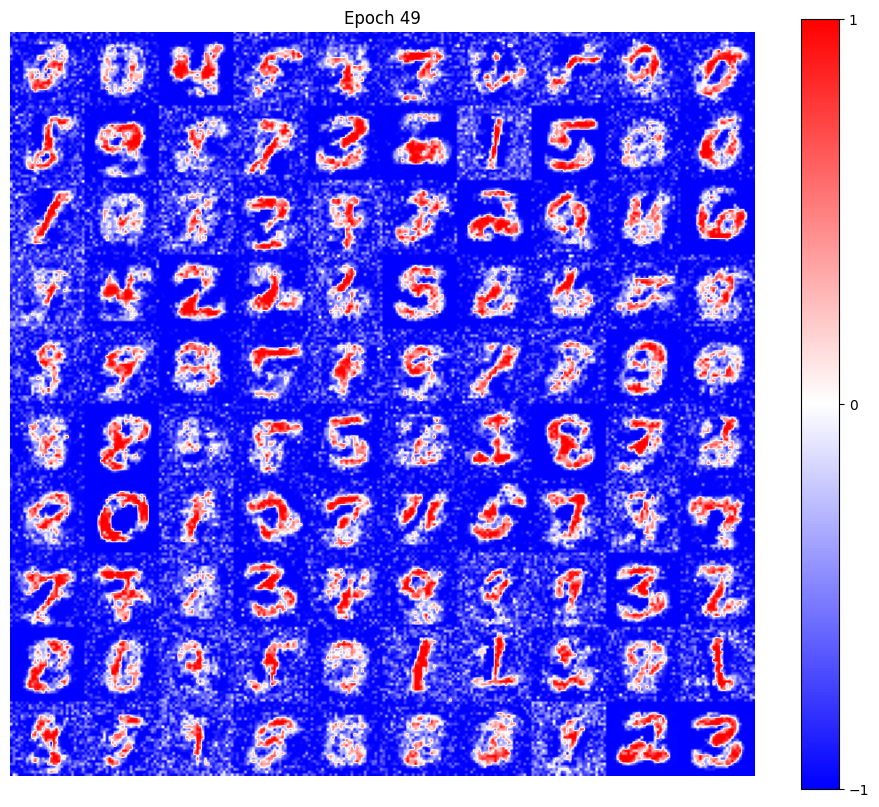

In [ ]:
draw_heatmap(KS[:, :N], Kx, Ky, fig=fig, title=f'Epoch {nep}')


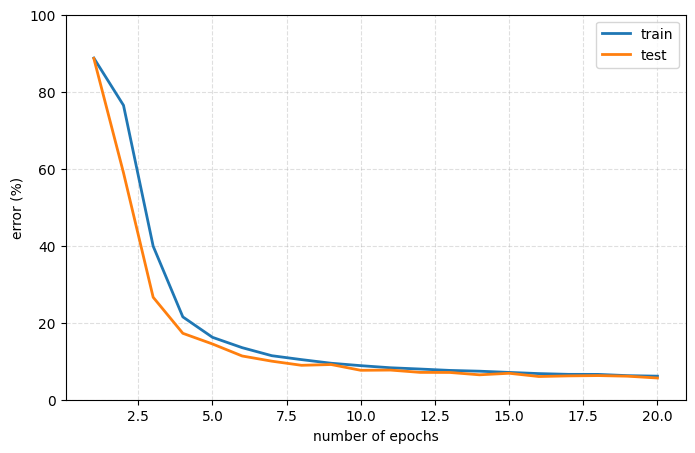

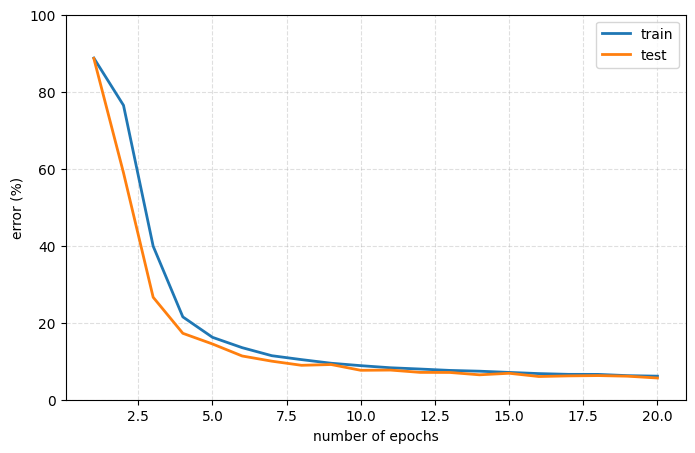

In [25]:
plot_errors(err_tr, err_test, save_path=None)